In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
#some funtions for easy print
from IPython.display import display, Markdown
from typing import Any

#def pretty_print(message: str) -> str:
#    display(Markdown(message))
def pretty_print(message: str) -> None:
    display(Markdown(f"```markdown\n{message}\n```"))

def format_output(data: Any, indent=0) -> str:
    spacing = ' ' * indent
    if isinstance(data, dict):
        result = []
        for key, value in data.items():
            result.append(f"{spacing}{key}: {format_output(value, indent + 4)}")
        return "\n".join(result)
    elif isinstance(data, list):
        result = []
        for item in data:
            result.append(format_output(item, indent + 4))
        return "\n".join(result)
    elif isinstance(data, BaseMessage):
        return f"{spacing}{type(data).__name__}(content='{data.content}', name='{data.name}')"
    else:
        return f"{spacing}{str(data)}"



Title: Tele-Mental Health Service: Unveiling the Disparity and Impact on Healthcare Access and Expenditures during the COVID-19 Pandemic in Mississippi.
PMID: 39063396

Title: Double Trouble: COVID-19 Infection Exacerbates Sickle Cell Crisis Outcomes in Hospitalized Patients-Insights from National Inpatient Sample 2020.
PMID: 39051414

In [3]:
from langchain_openai import OpenAIEmbeddings
import os
from typing import List
from langchain_community.document_loaders import PyMuPDFLoader
import uuid

from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import (
    ConversationalRetrievalChain,
)
from langchain.document_loaders import PyPDFLoader
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.docstore.document import Document
from langchain.memory import ChatMessageHistory, ConversationBufferMemory
from chainlit.types import AskFileResponse

import chainlit as cl
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_huggingface import HuggingFaceEmbeddings

2024-10-09 14:25:35 - Loaded .env file


# set up basic RAG chain (will use it as a tool later). The RAG chain contains the information about 2 papers.
Title: Tele-Mental Health Service: Unveiling the Disparity and Impact on Healthcare Access and Expenditures during the COVID-19 Pandemic in Mississippi.
PMID: 39063396

Title: Double Trouble: COVID-19 Infection Exacerbates Sickle Cell Crisis Outcomes in Hospitalized Patients-Insights from National Inpatient Sample 2020.
PMID: 39051414


In [7]:
pdf_links = [
"https://www.mdpi.com/1660-4601/21/7/819/pdf",
"https://www.mdpi.com/2038-8330/16/3/41/pdf"]

documents = []
for pdf_link in pdf_links:
    loader = PyMuPDFLoader(pdf_link)
    loaded_docs = loader.load()
    documents.extend(loaded_docs)

    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=CHUNK_SIZE,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
    )
split_chunks = text_splitter.split_documents(documents)
print(len(split_chunks))
split_chunks[0]

107


Document(metadata={'source': 'https://www.mdpi.com/1660-4601/21/7/819/pdf', 'file_path': 'https://www.mdpi.com/1660-4601/21/7/819/pdf', 'page': 0, 'total_pages': 11, 'format': 'PDF 1.7', 'title': 'Tele-Mental Health Service: Unveiling the Disparity and Impact on Healthcare Access and Expenditures during the COVID-19 Pandemic in Mississippi', 'author': 'Yunxi Zhang, Lincy S. Lal, Yueh-Yun Lin, J. Michael Swint, Ying Zhang, Richard L. Summers, Barbara F. Jones, Saurabh Chandra and Mark E. Ladner', 'subject': 'During the COVID-19 pandemic, tele-mental health (TMH) was a viable approach for providing accessible mental and behavioral health (MBH) services. This study examines the sociodemographic disparities in TMH utilization and its effects on healthcare resource utilization (HCRU) and medical expenditures in Mississippi. Utilizing a cohort of 6787 insured adult patients at the University of Mississippi Medical Center and its affiliated sites between January 2020 and June 2023, including 

In [11]:
EMBEDDING_MODEL = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)

LOCATION = ":memory:"
COLLECTION_NAME = "PubMed"
VECTOR_SIZE = 1536


qdrant_client = QdrantClient(LOCATION)

qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings,
)


2024-10-09 14:42:52 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [12]:
qdrant_vector_store.add_documents(split_chunks)
qdrant_retriever = qdrant_vector_store.as_retriever()

2024-10-09 14:42:54 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-09 14:42:55 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [13]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful assistant. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [14]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

In [15]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

In [16]:
pretty_print(rag_chain.invoke({"question" : "What is Tele-mental health (TMH) services?"}))

2024-10-09 14:44:24 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-09 14:44:27 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


```markdown
Tele-mental health (TMH) services leverage telecommunication and videoconferencing technologies to facilitate decentralized mental and behavioral healthcare. This approach allows patients in remote locations to access mental health services, overcoming geographical barriers and improving healthcare access, particularly in underserved rural communities. During the COVID-19 pandemic, TMH emerged as a viable solution for providing accessible mental and behavioral health services.
```

# set up agents

In [23]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools
from IPython.display import Image, display
llm = ChatOpenAI(model="gpt-4-turbo")

In [18]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [19]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

In [35]:
@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about 2 papers:
  Paper 1: Tele-Mental Health Service: Unveiling the Disparity and Impact on Healthcare Access and Expenditures during the COVID-19 Pandemic in Mississippi.
  Paper 2: Double Trouble: COVID-19 Infection Exacerbates Sickle Cell Crisis Outcomes in Hospitalized Patients-Insights from National Inpatient Sample 2020."""
  return rag_chain.invoke({"question" : query})

@tool
def create_citation(
    points: Annotated[List[str], "cite the correct source paper and add citations/reference numbers inside to the paragraph. At the end of the paragraph, make a list of paper you referenced."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Added and saved citations."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"citation saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [36]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

In [21]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [37]:
doc_writer_agent = create_agent(
    llm,
    [retrieve_information,write_document, edit_document, read_document],
    ("You are an expert writing paper summarization.\n"
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)


citation_agent = create_agent(
    llm,
    [create_citation, write_document, edit_document, read_document],
    ("You are an expert in research citation. You will add citations numbers inside the research summarization and at the end of the paragraph, create a citation list.\n"
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_citation_agent = prelude | citation_agent
citation_node = functools.partial(
    agent_node, agent=context_aware_citation_agent, name="CiteEditor"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in research ariticle editing who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"
    "You may only speak as your role. You must not speak as any other roles."),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)


doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "CiteEditor","CopyEditor"],
)

In [38]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("CiteEditor", citation_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "CiteEditor")
authoring_graph.add_edge("CiteEditor", "CopyEditor")
authoring_graph.add_edge("CopyEditor", "supervisor")



authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "CiteEditor": "CiteEditor",
        "CopyEditor" : "CopyEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
chain_linkedin = authoring_graph.compile()

## the whole team

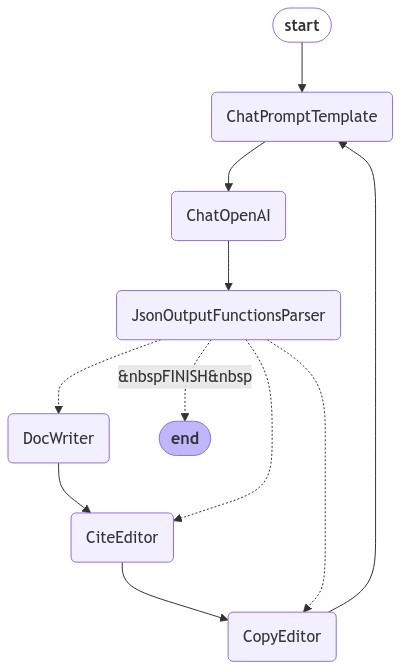

In [39]:
from IPython.display import Image, display

try:
    display(Image(chain_linkedin.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [40]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

## sample run

In [42]:
for s in authoring_chain.stream(
    """Write an detailed summary about: 
    Paper 1: Tele-Mental Health Service: Unveiling the Disparity and Impact on Healthcare Access and Expenditures during the COVID-19 Pandemic in Mississippi.
    Paper 2: Double Trouble: COVID-19 Infection Exacerbates Sickle Cell Crisis Outcomes in Hospitalized Patients-Insights from National Inpatient Sample 2020.
    make sure to include citations numbers inside the text you created and at the end of the paragraph, create a citation list. At lst, write it to disk.""",
    {"recursion_limit": 10},
):
    if "__end__" not in s:
        print(s)
        print("---")

2024-10-10 14:31:41 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'supervisor': {'next': 'DocWriter'}}
---
2024-10-10 14:31:42 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-10 14:31:43 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-10 14:31:47 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-10 14:31:48 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-10 14:31:50 - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-10 14:31:53 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-10 14:31:55 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-10 14:32:25 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
{'DocWriter': {'messages': [HumanMessage(content='Th